In [1]:
# dependencies
# possibly more than needed
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress
import chardet
import gmaps

# Import API key
from api_keys import g_key

In [2]:
# Make list of column/headers for Great Big Dataframe (GBDf) with empty cells - Paul

# FIPS
# (five-digit code: the first two represent state, the last three represent county in that state)

# County
# (name, e.g. Jackson County in many states, but also Orleans Parish of Louisiana, or the Aleutians East Borough of Alaska)

# State (name)

# Pop
# (2019 county population estimate)

# PopDens
# (Population density; derived from county 2019 population estimate divided by county land mass in another dataframe)

# MskScore
# (Mask-wearing score derived from pct in each county who said never, rarely sometimes, frequently, always wear a mask when going out)

# CaseRate
# (cumulative COVID cases per 100,000 population by county January 21–July 14, 2020)

# DeathRate
# (cumulative COVID deaths per 100,000 population by county January 21–July 14, 2020)

# Income
# (Mean per-capita income by county; this is a bonus-round question)

In [3]:
# Create GBDf
columnNames = ["FIPS", "County", "State", "Pop", "PopDens", "MskScore", "CaseRate", "DeathRate", "Income"]
GBDf = pd.DataFrame(columns = columnNames)
# placeholderData = ["01001", "Autauga", "Alabama", "55869", "94.0", "7.51", "0", "1335", "32"]
placeholderData = {"FIPS":"01001", "County":"Autauga", "State":"Alabama", "Pop":55869, "PopDens":94.0, "MskScore":7.51, "CaseRate":1335, "DeathRate":32, "Income":0}
GBDf = GBDf.append(placeholderData, ignore_index=True)
GBDf

,FIPS,County,State,Pop,PopDens,MskScore,CaseRate,DeathRate,Income
0,01001,Autauga,Alabama,55869,94.0,7.51,1335,32,0


In [4]:
# Matt's code starts here

In [5]:
# 1. US Census 2010-2019
censusDataReadMeURL = "https://www.census.gov/data/tables/time-series/demo/popest/2010s-counties-total.html"

# This is where the census data .CSV lives locally...:
censusDataFilepath = "Resources/co-est2019-alldata_exp.csv"

print(f"{censusDataFilepath} is {round(os.path.getsize(censusDataFilepath)/1024/1024, 2)} megabytes (MB).\nMore info here:\n{censusDataReadMeURL}")

Resources/co-est2019-alldata_exp.csv is 0.15 megabytes (MB).
More info here:
https://www.census.gov/data/tables/time-series/demo/popest/2010s-counties-total.html


In [6]:
# Read CSV into censusData DataFrame
censusData = pd.read_csv(censusDataFilepath, encoding="iso-8859-1")
censusData

,FIPS,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,POPESTIMATE2019
0,1001,1,1,Alabama,Autauga County,54571,55869
1,1003,1,3,Alabama,Baldwin County,182265,223234
2,1005,1,5,Alabama,Barbour County,27457,24686
3,1007,1,7,Alabama,Bibb County,22915,22394
4,1009,1,9,Alabama,Blount County,57322,57826
...,...,...,...,...,...,...,...
3137,56037,56,37,Wyoming,Sweetwater County,43806,42343
3138,56039,56,39,Wyoming,Teton County,21294,23464
3139,56041,56,41,Wyoming,Uinta County,21118,20226
3140,56043,56,43,Wyoming,Washakie County,8533,7805


In [7]:
# censusData.dtypes

In [8]:
# Aleena's code ends here for now

In [9]:
# Matt's code starts here

In [10]:
# 2. COVID-19 cases
caseDataReadMeURL = "https://github.com/nytimes/covid-19-data/blob/master/README.md"

# This is where the .CSV lives locally...:
caseDataFilepath = "Resources/us-counties.csv"

print(f"The file at {caseDataFilepath} is {round(os.path.getsize(caseDataFilepath)/1024/1024, 2)} MB.\nMore info here:\n{caseDataReadMeURL}")

The file at Resources/us-counties.csv is 0.12 MB.
More info here:
https://github.com/nytimes/covid-19-data/blob/master/README.md


In [11]:
# Read CSV into caseData DataFrame
caseData = pd.read_csv(caseDataFilepath, encoding = "UTF-8")
caseData

,date,county,state,fips,cases,deaths
0,7/14/2020,Autauga,Alabama,1001.0,746,18
1,7/14/2020,Baldwin,Alabama,1003.0,1414,12
2,7/14/2020,Barbour,Alabama,1005.0,428,3
3,7/14/2020,Bibb,Alabama,1007.0,236,2
4,7/14/2020,Blount,Alabama,1009.0,366,1
...,...,...,...,...,...,...
3155,7/14/2020,Unknown,North Dakota,NaN,4,4
3156,7/14/2020,Unknown,Rhode Island,NaN,2085,30
3157,7/14/2020,Unknown,Utah,NaN,0,9
3158,7/14/2020,Unknown,Vermont,NaN,5,0


In [12]:
# caseData.dtypes

In [13]:
# Drop rows containing NaN values (caseData's "unknown" counties)
caseData.dropna(axis = 0, how = "any", thresh = None, subset = None, inplace = True)
caseData

,date,county,state,fips,cases,deaths
0,7/14/2020,Autauga,Alabama,1001.0,746,18
1,7/14/2020,Baldwin,Alabama,1003.0,1414,12
2,7/14/2020,Barbour,Alabama,1005.0,428,3
3,7/14/2020,Bibb,Alabama,1007.0,236,2
4,7/14/2020,Blount,Alabama,1009.0,366,1
...,...,...,...,...,...,...
3131,7/14/2020,Teton,Wyoming,56039.0,164,1
3132,7/14/2020,Uinta,Wyoming,56041.0,208,0
3133,7/14/2020,Washakie,Wyoming,56043.0,42,5
3134,7/14/2020,Weston,Wyoming,56045.0,3,0


In [14]:
# Convert caseData FIPS values from float64 to int64
caseData.fips = caseData.fips.astype(np.int64)
caseData.dtypes

date      object
county    object
state     object
fips       int64
cases      int64
deaths     int64
dtype: object

In [15]:
# caseData

,date,county,state,fips,cases,deaths
0,7/14/2020,Autauga,Alabama,1001,746,18
1,7/14/2020,Baldwin,Alabama,1003,1414,12
2,7/14/2020,Barbour,Alabama,1005,428,3
3,7/14/2020,Bibb,Alabama,1007,236,2
4,7/14/2020,Blount,Alabama,1009,366,1
...,...,...,...,...,...,...
3131,7/14/2020,Teton,Wyoming,56039,164,1
3132,7/14/2020,Uinta,Wyoming,56041,208,0
3133,7/14/2020,Washakie,Wyoming,56043,42,5
3134,7/14/2020,Weston,Wyoming,56045,3,0


In [16]:
# Merge caseData and censusData DataFrames
merged_caseData = pd.merge(censusData, caseData, how = "outer", left_on = "FIPS", right_on = "fips", on=None, sort=False, copy=True, indicator=False, validate=None)
merged_caseData

,FIPS,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,POPESTIMATE2019,date,county,state,fips,cases,deaths
0,1001.0,1.0,1.0,Alabama,Autauga County,54571.0,55869.0,7/14/2020,Autauga,Alabama,1001.0,746.0,18.0
1,1003.0,1.0,3.0,Alabama,Baldwin County,182265.0,223234.0,7/14/2020,Baldwin,Alabama,1003.0,1414.0,12.0
2,1005.0,1.0,5.0,Alabama,Barbour County,27457.0,24686.0,7/14/2020,Barbour,Alabama,1005.0,428.0,3.0
3,1007.0,1.0,7.0,Alabama,Bibb County,22915.0,22394.0,7/14/2020,Bibb,Alabama,1007.0,236.0,2.0
4,1009.0,1.0,9.0,Alabama,Blount County,57322.0,57826.0,7/14/2020,Blount,Alabama,1009.0,366.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138,56039.0,56.0,39.0,Wyoming,Teton County,21294.0,23464.0,7/14/2020,Teton,Wyoming,56039.0,164.0,1.0
3139,56041.0,56.0,41.0,Wyoming,Uinta County,21118.0,20226.0,7/14/2020,Uinta,Wyoming,56041.0,208.0,0.0
3140,56043.0,56.0,43.0,Wyoming,Washakie County,8533.0,7805.0,7/14/2020,Washakie,Wyoming,56043.0,42.0,5.0
3141,56045.0,56.0,45.0,Wyoming,Weston County,7208.0,6927.0,7/14/2020,Weston,Wyoming,56045.0,3.0,0.0


In [17]:
# Drop duplicate and/or irrelevant columns
merged_caseData.drop(columns=["FIPS", "STATE", "COUNTY", "STNAME", "CTYNAME", "CENSUS2010POP"], inplace = True)
merged_caseData.head()

,POPESTIMATE2019,date,county,state,fips,cases,deaths
0,55869.0,7/14/2020,Autauga,Alabama,1001.0,746.0,18.0
1,223234.0,7/14/2020,Baldwin,Alabama,1003.0,1414.0,12.0
2,24686.0,7/14/2020,Barbour,Alabama,1005.0,428.0,3.0
3,22394.0,7/14/2020,Bibb,Alabama,1007.0,236.0,2.0
4,57826.0,7/14/2020,Blount,Alabama,1009.0,366.0,1.0
...,...,...,...,...,...,...,...
3138,23464.0,7/14/2020,Teton,Wyoming,56039.0,164.0,1.0
3139,20226.0,7/14/2020,Uinta,Wyoming,56041.0,208.0,0.0
3140,7805.0,7/14/2020,Washakie,Wyoming,56043.0,42.0,5.0
3141,6927.0,7/14/2020,Weston,Wyoming,56045.0,3.0,0.0


In [18]:
# Export to CSV to manually look for rows with NaN
# merged_caseData.to_csv("merged_caseData.csv", index = False, header = False)

,POPESTIMATE2019,date,county,state,fips,cases,deaths
0,55869.0,7/14/2020,Autauga,Alabama,1001.0,746.0,18.0
1,223234.0,7/14/2020,Baldwin,Alabama,1003.0,1414.0,12.0
2,24686.0,7/14/2020,Barbour,Alabama,1005.0,428.0,3.0
3,22394.0,7/14/2020,Bibb,Alabama,1007.0,236.0,2.0
4,57826.0,7/14/2020,Blount,Alabama,1009.0,366.0,1.0
...,...,...,...,...,...,...,...
3138,23464.0,7/14/2020,Teton,Wyoming,56039.0,164.0,1.0
3139,20226.0,7/14/2020,Uinta,Wyoming,56041.0,208.0,0.0
3140,7805.0,7/14/2020,Washakie,Wyoming,56043.0,42.0,5.0
3141,6927.0,7/14/2020,Weston,Wyoming,56045.0,3.0,0.0


In [ ]:
# Manually add population to row 3142 (New York City aggregate)
merged_caseData["POPESTIMATE2019"][3142] = 8336817
merged_caseData.tail()

In [19]:
# merged_caseData.dtypes

In [20]:
# Rearrange columns
organized_caseData = merged_caseData[["date", "fips", "county", "state", "POPESTIMATE2019", "cases", "deaths"]]
organized_caseData.head()

,date,fips,county,state,POPESTIMATE2019,cases,deaths
0,7/14/2020,1001.0,Autauga,Alabama,55869.0,746.0,18.0
1,7/14/2020,1003.0,Baldwin,Alabama,223234.0,1414.0,12.0
2,7/14/2020,1005.0,Barbour,Alabama,24686.0,428.0,3.0
3,7/14/2020,1007.0,Bibb,Alabama,22394.0,236.0,2.0
4,7/14/2020,1009.0,Blount,Alabama,57826.0,366.0,1.0
...,...,...,...,...,...,...,...
3138,7/14/2020,56039.0,Teton,Wyoming,23464.0,164.0,1.0
3139,7/14/2020,56041.0,Uinta,Wyoming,20226.0,208.0,0.0
3140,7/14/2020,56043.0,Washakie,Wyoming,7805.0,42.0,5.0
3141,7/14/2020,56045.0,Weston,Wyoming,6927.0,3.0,0.0


In [21]:
# Rename columns
renamed_caseData = merged_caseData.rename(columns={"date":"Date", "fips":"FIPS", "county":"County", "state":"State",
                                                   "POPESTIMATE2019":"PopEst", "cases":"Cases", "deaths":"Deaths"})
renamed_caseData.head()

,PopEst,Date,County,State,FIPS,Cases,Deaths
0,55869.0,7/14/2020,Autauga,Alabama,1001.0,746.0,18.0
1,223234.0,7/14/2020,Baldwin,Alabama,1003.0,1414.0,12.0
2,24686.0,7/14/2020,Barbour,Alabama,1005.0,428.0,3.0
3,22394.0,7/14/2020,Bibb,Alabama,1007.0,236.0,2.0
4,57826.0,7/14/2020,Blount,Alabama,1009.0,366.0,1.0
...,...,...,...,...,...,...,...
3138,23464.0,7/14/2020,Teton,Wyoming,56039.0,164.0,1.0
3139,20226.0,7/14/2020,Uinta,Wyoming,56041.0,208.0,0.0
3140,7805.0,7/14/2020,Washakie,Wyoming,56043.0,42.0,5.0
3141,6927.0,7/14/2020,Weston,Wyoming,56045.0,3.0,0.0


In [22]:
# Rearrange columns
reorganized_caseData = renamed_caseData[["Date", "FIPS", "County", "State", "PopEst", "Cases", "Deaths"]]
reorganized_caseData

,Date,FIPS,County,State,PopEst,Cases,Deaths
0,7/14/2020,1001.0,Autauga,Alabama,55869.0,746.0,18.0
1,7/14/2020,1003.0,Baldwin,Alabama,223234.0,1414.0,12.0
2,7/14/2020,1005.0,Barbour,Alabama,24686.0,428.0,3.0
3,7/14/2020,1007.0,Bibb,Alabama,22394.0,236.0,2.0
4,7/14/2020,1009.0,Blount,Alabama,57826.0,366.0,1.0
...,...,...,...,...,...,...,...
3138,7/14/2020,56039.0,Teton,Wyoming,23464.0,164.0,1.0
3139,7/14/2020,56041.0,Uinta,Wyoming,20226.0,208.0,0.0
3140,7/14/2020,56043.0,Washakie,Wyoming,7805.0,42.0,5.0
3141,7/14/2020,56045.0,Weston,Wyoming,6927.0,3.0,0.0


In [23]:
# reorganized_caseData.dtypes

In [24]:
# Due diligence to check dataset for rows with missing data
reorganized_caseData.count()

Date      3136
FIPS      3136
County    3136
State     3136
PopEst    3143
Cases     3136
Deaths    3136
dtype: int64

In [25]:
# Drop rows containing no data and reset index
complete_caseData = reorganized_caseData.dropna(axis = 0, how = "any", thresh = None, subset = None, inplace = False)
complete_caseData = complete_caseData.reset_index()
complete_caseData.tail()

,Date,FIPS,County,State,PopEst,Cases,Deaths
0,7/14/2020,1001.0,Autauga,Alabama,55869.0,746.0,18.0
1,7/14/2020,1003.0,Baldwin,Alabama,223234.0,1414.0,12.0
2,7/14/2020,1005.0,Barbour,Alabama,24686.0,428.0,3.0
3,7/14/2020,1007.0,Bibb,Alabama,22394.0,236.0,2.0
4,7/14/2020,1009.0,Blount,Alabama,57826.0,366.0,1.0
...,...,...,...,...,...,...,...
3138,7/14/2020,56039.0,Teton,Wyoming,23464.0,164.0,1.0
3139,7/14/2020,56041.0,Uinta,Wyoming,20226.0,208.0,0.0
3140,7/14/2020,56043.0,Washakie,Wyoming,7805.0,42.0,5.0
3141,7/14/2020,56045.0,Weston,Wyoming,6927.0,3.0,0.0


In [ ]:
# Create DataFrame containing (4) boroughs of New York (New York County (Manhattan) dropped out on previous cell) so their
# population data is not counted twice
droppedNYData = complete_caseData.loc[(complete_caseData["State"] == "New York") & (complete_caseData["Cases"] == 0), :]
droppedNYData

In [ ]:
# Remove droppedNYData DataFrame from complete_caseData DataFrame and reset index
final_caseData_index = droppedNYData.index
final_caseData = complete_caseData.drop(final_caseData_index, inplace = False)
final_caseData = final_caseData.reset_index()
final_caseData.tail()

In [26]:
# Drop duplicate and/or irrelevant columns
final_caseData.drop(columns=["level_0", "index"], inplace = True)
final_caseData.head()

,Date,FIPS,County,State,PopEst,Cases,Deaths
0,7/14/2020,1001.0,Autauga,Alabama,55869.0,746.0,18.0
1,7/14/2020,1003.0,Baldwin,Alabama,223234.0,1414.0,12.0
2,7/14/2020,1005.0,Barbour,Alabama,24686.0,428.0,3.0
3,7/14/2020,1007.0,Bibb,Alabama,22394.0,236.0,2.0
4,7/14/2020,1009.0,Blount,Alabama,57826.0,366.0,1.0
...,...,...,...,...,...,...,...
3138,7/14/2020,56039.0,Teton,Wyoming,23464.0,164.0,1.0
3139,7/14/2020,56041.0,Uinta,Wyoming,20226.0,208.0,0.0
3140,7/14/2020,56043.0,Washakie,Wyoming,7805.0,42.0,5.0
3141,7/14/2020,56045.0,Weston,Wyoming,6927.0,3.0,0.0


In [27]:
# Export to CSV to verify all (5) boroughs have been dropped
# final_caseData.to_csv("final_caseData.csv", index = False, header = True)

In [28]:
# Convert final_caseData FIPS values from float64 to int64
final_caseData.FIPS = final_caseData.FIPS.astype(np.int64)
# final_caseData.dtypes

In [29]:
# 3. Landmass (and thence population density)
landMassDataReadMeURL = "https://hub.arcgis.com/datasets/48f9af87daa241c4b267c5931ad3b226_0/data?orderBy=FIPS"
# This is where the land mass data .CSV lives locally...:
landMassDataFilepath = "Resources/counties-by-land-area.csv"

print(f"{landMassDataFilepath} is {round(os.path.getsize(landMassDataFilepath)/1024/1024, 2)} MB.\nMore info here:\n{landMassDataReadMeURL}")

Resources/counties-by-land-area.csv is 0.99 MB.
More info here:
https://hub.arcgis.com/datasets/48f9af87daa241c4b267c5931ad3b226_0/data?orderBy=FIPS


In [30]:
# Read CSV into landmassData DataFrame
landmassData = pd.read_csv(landMassDataFilepath)
landmassData

In [31]:
# landmassData.dtypes

,FID,OBJECTID,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,POPULATION,POP_SQMI,POP2010,...,OWNER_OCC,RENTER_OCC,NO_FARMS12,AVE_SIZE12,CROP_ACR12,AVE_SALE12,SQMI,Shape_Leng,SHAPE_Length,SHAPE_Area
0,1,1,Kauai,Hawaii,15,7,15007,73169,116.8,67091,...,13968,9272,591,244,30236,109160,626.57,2.938884,2.938884,0.141970
1,2,2,Honolulu,Hawaii,15,3,15003,1014211,1681.1,953207,...,174387,136660,999,69,22200,161650,603.31,4.223576,4.223580,0.136184
2,3,3,Hawaii,Hawaii,15,1,15001,204027,50.7,185079,...,44271,22825,4282,160,72028,57741,4027.83,5.616467,5.616467,0.898318
3,4,4,Kalawao,Hawaii,15,5,15005,91,7.6,90,...,1,68,-99,-99,-99,-99,12.03,0.509271,0.509271,0.002709
4,5,5,Maui,Hawaii,15,9,15009,169713,146.3,154834,...,30055,23831,1128,203,49578,166755,1159.64,6.359883,6.359882,0.260689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,3216,3216,Aroostook,Maine,23,3,23003,70995,10.4,71870,...,22037,8924,895,392,187479,235215,6828.89,8.081154,8.081154,2.078769
3216,3217,3217,Penobscot,Maine,23,19,23019,157026,44.2,153923,...,42981,19985,677,167,35578,74084,3556.09,6.546183,6.546183,1.058448
3217,3218,3218,Piscataquis,Maine,23,21,23021,17258,3.9,17535,...,6055,1770,203,230,12387,0,4377.58,6.004977,6.004977,1.313017
3218,3219,3219,Washington,Maine,23,29,23029,32358,11.7,32856,...,10790,3512,392,380,35706,394506,2757.41,17.906023,17.906018,0.815570


In [32]:
# Reset index
landmassData = landmassData.reset_index()
landmassData.tail()

In [33]:
# landmassData.shape

,FID,OBJECTID,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,POPULATION,POP_SQMI,POP2010,...,OWNER_OCC,RENTER_OCC,NO_FARMS12,AVE_SIZE12,CROP_ACR12,AVE_SALE12,SQMI,Shape_Leng,SHAPE_Length,SHAPE_Area
0,1,1,Kauai,Hawaii,15,7,15007,73169,116.8,67091,...,13968,9272,591,244,30236,109160,626.57,2.938884,2.938884,0.141970
1,2,2,Honolulu,Hawaii,15,3,15003,1014211,1681.1,953207,...,174387,136660,999,69,22200,161650,603.31,4.223576,4.223580,0.136184
2,3,3,Hawaii,Hawaii,15,1,15001,204027,50.7,185079,...,44271,22825,4282,160,72028,57741,4027.83,5.616467,5.616467,0.898318
3,4,4,Kalawao,Hawaii,15,5,15005,91,7.6,90,...,1,68,-99,-99,-99,-99,12.03,0.509271,0.509271,0.002709
4,5,5,Maui,Hawaii,15,9,15009,169713,146.3,154834,...,30055,23831,1128,203,49578,166755,1159.64,6.359883,6.359882,0.260689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,3138,3138,Hamilton,New York,36,41,36041,4593,2.5,4836,...,1826,436,26,80,251,13390,1807.72,3.452486,3.452486,0.522430
3138,3139,3139,Saratoga,New York,36,91,36091,234223,277.7,219607,...,64205,24091,583,135,43818,137167,843.59,2.540533,2.540533,0.241608
3139,3140,3140,Washington,New York,36,115,36115,63674,75.2,63216,...,17722,6420,851,223,101904,163510,846.19,3.034919,3.034919,0.243165
3140,3141,3141,Warren,New York,36,113,36113,66980,71.9,65707,...,19389,8601,117,81,1475,0,931.47,2.856069,2.856069,0.268750


In [34]:
# final_caseData.head()

In [35]:
# Create DataFrame to sort landmassData by FIPS code
a = landmassData[['FIPS','FID','NAME','STATE_NAME','STATE_NAME','POPULATION','SQMI']]
a = a.sort_values(by='FIPS').reset_index().drop(columns=['index'])
a.tail()

In [36]:
# Create DataFrame to sort final_caseData by FIPS code
b = final_caseData[['Date','FIPS','County','State','Cases','Deaths']]
b = b.sort_values(by='FIPS').reset_index().drop(columns=['index'])
b.tail()

,Date,FIPS,County,State,PopEst,Cases,Deaths,FID,OBJECTID,NAME,...,OWNER_OCC,RENTER_OCC,NO_FARMS12,AVE_SIZE12,CROP_ACR12,AVE_SALE12,SQMI,Shape_Leng,SHAPE_Length,SHAPE_Area
0,7/14/2020,1001.0,Autauga,Alabama,55869.0,746.0,18.0,1177.0,1177.0,Autauga,...,15248.0,4973.0,389.0,287.0,41293.0,50929.0,604.13,2.137270,2.137269,0.150197
1,7/14/2020,1003.0,Baldwin,Alabama,223234.0,1414.0,12.0,397.0,397.0,Baldwin,...,53071.0,20109.0,989.0,194.0,100901.0,137069.0,1640.33,6.675636,6.675636,0.400160
2,7/14/2020,1005.0,Barbour,Alabama,24686.0,428.0,3.0,1213.0,1213.0,Barbour,...,6556.0,3264.0,571.0,358.0,41301.0,182761.0,904.49,2.690816,2.690816,0.223268
3,7/14/2020,1007.0,Bibb,Alabama,22394.0,236.0,2.0,1193.0,1193.0,Bibb,...,6011.0,1942.0,189.0,298.0,12608.0,0.0,626.18,1.895116,1.895116,0.156476
4,7/14/2020,1009.0,Blount,Alabama,57826.0,366.0,1.0,1199.0,1199.0,Blount,...,17384.0,4194.0,1241.0,118.0,37147.0,143586.0,650.63,2.452107,2.452107,0.164407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3127,7/14/2020,56039.0,Teton,Wyoming,23464.0,164.0,1.0,1983.0,1983.0,Teton,...,5083.0,3890.0,154.0,261.0,10545.0,58676.0,4216.98,5.162437,5.162437,1.224228
3128,7/14/2020,56041.0,Uinta,Wyoming,20226.0,208.0,0.0,202.0,202.0,Uinta,...,5759.0,1909.0,315.0,2064.0,68719.0,94815.0,2087.57,3.158515,3.158515,0.581167
3129,7/14/2020,56043.0,Washakie,Wyoming,7805.0,42.0,5.0,253.0,253.0,Washakie,...,2560.0,932.0,209.0,1633.0,39942.0,248154.0,2242.72,4.251011,4.251011,0.650754
3130,7/14/2020,56045.0,Weston,Wyoming,6927.0,3.0,0.0,2034.0,2034.0,Weston,...,2349.0,672.0,264.0,4888.0,57046.0,197832.0,2399.99,3.419619,3.419619,0.695642


In [37]:
# Convert final_caseData FIPS values to int32 and verify data types
b['FIPS'] = b['FIPS'].astype(int)
b.dtypes

In [38]:
# Verify landmassData data types
a.dtypes

Date            3132
FIPS            3132
County          3132
State           3132
PopEst          3132
                ... 
AVE_SALE12      3053
SQMI            3053
Shape_Leng      3053
SHAPE_Length    3053
SHAPE_Area      3053
Length: 64, dtype: int64

In [39]:
# Verify last row's index number
b.tail()

In [40]:
# Calculate difference in rows between final_caseData and landmassData DataFrames to identify Puerto Rico and
# other non-U.S. "counties" we do not have case data for
len(a)-len(b)

,Date,FIPS,County,State,PopEst,Cases,Deaths,SQMI
0,7/14/2020,1001.0,Autauga,Alabama,55869.0,746.0,18.0,604.13
1,7/14/2020,1003.0,Baldwin,Alabama,223234.0,1414.0,12.0,1640.33
2,7/14/2020,1005.0,Barbour,Alabama,24686.0,428.0,3.0,904.49
3,7/14/2020,1007.0,Bibb,Alabama,22394.0,236.0,2.0,626.18
4,7/14/2020,1009.0,Blount,Alabama,57826.0,366.0,1.0,650.63
...,...,...,...,...,...,...,...,...
3127,7/14/2020,56039.0,Teton,Wyoming,23464.0,164.0,1.0,4216.98
3128,7/14/2020,56041.0,Uinta,Wyoming,20226.0,208.0,0.0,2087.57
3129,7/14/2020,56043.0,Washakie,Wyoming,7805.0,42.0,5.0,2242.72
3130,7/14/2020,56045.0,Weston,Wyoming,6927.0,3.0,0.0,2399.99


In [ ]:
# Create DataFrame to hold duplicate county with case data
c = b[b['FIPS'] == 2016]
c

In [ ]:
# Create DataFrame to hold duplicate county with census data
d = a[a['FIPS'] == 2016]
d

In [ ]:
# Merge DataFrames to remove duplicate county
final_merged_caseData = b.merge(a, how='left', on='FIPS')
final_merged_caseData.isnull().sum()

In [ ]:
# Verify merge was successful
check = final_merged_caseData[final_merged_caseData['FIPS'] == 2016]
check

In [ ]:
# View final_merged_caseData DataFrame to verify we have 3,132 rows (including New York City aggregate)
final_merged_caseData

In [41]:
# Drop duplicate and/or irrelevant columns
final_merged_caseData.drop(columns=["FID", "NAME", "STATE_NAME", "STATE_NAME"], inplace = True)
final_merged_caseData.head()

Date       object
FIPS      float64
County     object
State      object
PopEst    float64
Cases     float64
Deaths    float64
SQMI      float64
dtype: object

In [42]:
# Manually add population and landmass data to row 3142 (New York City aggregate)
final_merged_caseData["POPULATION"][3131] = 8336817
final_merged_caseData["SQMI"][3131] = 302.06
final_merged_caseData.tail()

In [ ]:
# Rename column
final_merged_caseData = final_merged_caseData.rename(columns={"POPULATION":"PopEst"})
final_merged_caseData

In [ ]:
# Export to CSV to manually look for rows with NaN
# final_merged_caseData.to_csv("final_merged_caseData.csv")

In [ ]:
# final_merged_caseData.dtypes

In [ ]:
# Calculate per 100,000 people factor
perHundredK_factor = final_merged_caseData["PopEst"] / 100000

# Calculate cases per 100,000
casesPerHundredK = final_merged_caseData["Cases"] / perHundredK_factor

# Calculate deaths per 100,000
deathsPerHundredK = final_merged_caseData["Deaths"] / perHundredK_factor

# Calculate population density
popDens = final_merged_caseData["PopEst"] / final_merged_caseData["SQMI"]

In [43]:
# Add new columns to hold case rates and death rates (per 100,000 people), and population density
final_merged_caseData["CaseRate"] = casesPerHundredK
final_merged_caseData["DeathRate"] = deathsPerHundredK
final_merged_caseData["PopDens"] = popDens
final_merged_caseData.head()

,Date,FIPS,County,State,PopEst,Cases,Deaths,SQMI,CaseRate,DeathRate,PopDens
0,7/14/2020,1001.0,Autauga,Alabama,55869.0,746.0,18.0,604.13,1335.266427,32.218225,92.478440
1,7/14/2020,1003.0,Baldwin,Alabama,223234.0,1414.0,12.0,1640.33,633.416057,5.375525,136.090909
2,7/14/2020,1005.0,Barbour,Alabama,24686.0,428.0,3.0,904.49,1733.776229,12.152637,27.292728
3,7/14/2020,1007.0,Bibb,Alabama,22394.0,236.0,2.0,626.18,1053.853711,8.930964,35.762880
4,7/14/2020,1009.0,Blount,Alabama,57826.0,366.0,1.0,650.63,632.933283,1.729326,88.876935
...,...,...,...,...,...,...,...,...,...,...,...
3127,7/14/2020,56039.0,Teton,Wyoming,23464.0,164.0,1.0,4216.98,698.943062,4.261848,5.564172
3128,7/14/2020,56041.0,Uinta,Wyoming,20226.0,208.0,0.0,2087.57,1028.379314,0.000000,9.688777
3129,7/14/2020,56043.0,Washakie,Wyoming,7805.0,42.0,5.0,2242.72,538.116592,64.061499,3.480149
3130,7/14/2020,56045.0,Weston,Wyoming,6927.0,3.0,0.0,2399.99,43.308792,0.000000,2.886262


In [44]:
# Reorganize columns
reorganized_final_merged_caseData = final_merged_caseData[["Date", "FIPS", "County", "State", "SQMI", "PopEst", "PopDens",
                                                           "Cases", "CaseRate", "Deaths", "DeathRate"]]
reorganized_final_merged_caseData.head()

,Date,FIPS,County,State,SQMI,PopEst,PopDens,Cases,CaseRate,Deaths,DeathRate
0,7/14/2020,1001.0,Autauga,Alabama,604.13,55869.0,92.478440,746.0,1335.266427,18.0,32.218225
1,7/14/2020,1003.0,Baldwin,Alabama,1640.33,223234.0,136.090909,1414.0,633.416057,12.0,5.375525
2,7/14/2020,1005.0,Barbour,Alabama,904.49,24686.0,27.292728,428.0,1733.776229,3.0,12.152637
3,7/14/2020,1007.0,Bibb,Alabama,626.18,22394.0,35.762880,236.0,1053.853711,2.0,8.930964
4,7/14/2020,1009.0,Blount,Alabama,650.63,57826.0,88.876935,366.0,632.933283,1.0,1.729326
...,...,...,...,...,...,...,...,...,...,...,...
3127,7/14/2020,56039.0,Teton,Wyoming,4216.98,23464.0,5.564172,164.0,698.943062,1.0,4.261848
3128,7/14/2020,56041.0,Uinta,Wyoming,2087.57,20226.0,9.688777,208.0,1028.379314,0.0,0.000000
3129,7/14/2020,56043.0,Washakie,Wyoming,2242.72,7805.0,3.480149,42.0,538.116592,5.0,64.061499
3130,7/14/2020,56045.0,Weston,Wyoming,2399.99,6927.0,2.886262,3.0,43.308792,0.0,0.000000


In [45]:
# Export to CSV for verification
# reorganized_final_merged_caseData.to_csv("reorganized_final_merged_caseData.csv", index = False, header = True)

In [46]:
# reorganized_final_merged_caseData.dtypes

In [47]:
# reorganized_final_merged_caseData.count()

C:\Users\Owner\anaconda3\envs\PythonData\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,Date,FIPS,County,State,SQMI,PopEst,PopDens,Cases,CaseRate,Deaths,DeathRate
0,7/14/2020,1001.0,Autauga,Alabama,604.13,55869.0,92.478440,746.0,1335.266427,18.0,32.218225
1,7/14/2020,1003.0,Baldwin,Alabama,1640.33,223234.0,136.090909,1414.0,633.416057,12.0,5.375525
2,7/14/2020,1005.0,Barbour,Alabama,904.49,24686.0,27.292728,428.0,1733.776229,3.0,12.152637
3,7/14/2020,1007.0,Bibb,Alabama,626.18,22394.0,35.762880,236.0,1053.853711,2.0,8.930964
4,7/14/2020,1009.0,Blount,Alabama,650.63,57826.0,88.876935,366.0,632.933283,1.0,1.729326
...,...,...,...,...,...,...,...,...,...,...,...
3127,7/14/2020,56039.0,Teton,Wyoming,4216.98,23464.0,5.564172,164.0,698.943062,1.0,4.261848
3128,7/14/2020,56041.0,Uinta,Wyoming,2087.57,20226.0,9.688777,208.0,1028.379314,0.0,0.000000
3129,7/14/2020,56043.0,Washakie,Wyoming,2242.72,7805.0,3.480149,42.0,538.116592,5.0,64.061499
3130,7/14/2020,56045.0,Weston,Wyoming,2399.99,6927.0,2.886262,3.0,43.308792,0.0,0.000000


In [48]:
# Convert reorganized_final_merged_caseData FIPS and Population values from float64 to int64
reorganized_final_merged_caseData.FIPS = reorganized_final_merged_caseData.FIPS.astype(np.int64)
reorganized_final_merged_caseData.PopEst = reorganized_final_merged_caseData.PopEst.astype(np.int64)
# reorganized_final_merged_caseData.dtypes

Date         3132
FIPS         3132
County       3132
State        3132
SQMI         3132
PopEst       3132
PopDens      3132
Cases        3132
CaseRate     3132
Deaths       3132
DeathRate    3132
dtype: int64

In [49]:
# Matt's DataFrame code ends here

Date          object
FIPS           int64
County        object
State         object
SQMI         float64
PopEst         int64
PopDens      float64
Cases        float64
CaseRate     float64
Deaths       float64
DeathRate    float64
dtype: object

In [ ]:
# Matt's heatmap code starts here

In [ ]:
# 4. County Centers (by geographic center latitude and longitude)
countyCenterDataReadMeURL = "https://github.com/btskinner/spatial/blob/master/data/county_centers.csv"

# This is where the county center data .CSV lives locally...:
countyCenterDataFilepath = "Resources/county_centers.csv"

print(f"{countyCenterDataFilepath} is {round(os.path.getsize(countyCenterDataFilepath)/1024/1024, 2)} MB.\nMore info here:\n{countyCenterDataReadMeURL}")

In [ ]:
# Read CSV into countyCenterData DataFrame
countyCenterData = pd.read_csv(countyCenterDataFilepath)
countyCenterData

In [ ]:
# Merge countyCenterData with reorganized_final_merged_caseData to create heatmap DataFrame
heatmapData = pd.merge(reorganized_final_merged_caseData, countyCenterData, how = "left", left_on = "FIPS", right_on = "fips", on = None, sort = False, copy = True, indicator = False, validate = None)
heatmapData

In [ ]:
# Drop duplicate and/or irrelevant columns
heatmapData.drop(columns = ["fips", "clon00", "clat00", "pclon00", "pclat00", "pclon10", "pclat10"], inplace = True)
heatmapData.head()

In [ ]:
# Rename columns
heatmapData = heatmapData.rename(columns={"clon10":"Longitude", "clat10":"Latitude"})
heatmapData.head()

In [ ]:
# Rearrange columns
heatmapData = heatmapData[["Date", "FIPS", "County", "State", "SQMI", "PopEst", "PopDens",
                           "Cases", "CaseRate", "Deaths", "DeathRate", "Latitude", "Longitude"]]
heatmapData.head()

In [ ]:
# Manually add latitude and longitude to New York City aggregate (FIPS 99999) and two rows missing coordinates data
heatmapData["Latitude"][81] = 62.09
heatmapData["Longitude"][81] = -163.53

heatmapData["Latitude"][2404] = 43.33
heatmapData["Longitude"][2404] = -102.55

heatmapData["Latitude"][3131] = 40.7420
heatmapData["Longitude"][3131] = -73.9073
heatmapData.tail()

In [ ]:
# Export to CSV for verification
# heatmapData.to_csv("heatmapData.csv", index = False, header = True)

In [ ]:
# Access maps with unique API key
gmaps.configure(api_key = g_key)

# COVID-19 Cases per 100,000 People on July 14, 2020

In [50]:
# Create heatmap for CaseRate

# Store latitude and longitude in locations
locations = heatmapData[["Latitude", "Longitude"]]

# Convert case rates to float
caseRate = heatmapData["CaseRate"].astype(float)

# Plot Heatmap
fig = gmaps.figure(zoom_level = 4.1, center = (37.8, -98.6))

# Set max intensity to highest case rate found in the dataset
max_intensity = heatmapData["CaseRate"].max()

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights = caseRate, 
                                 dissipating = False, max_intensity = max_intensity,
                                 point_radius = 1.05)

# Add layer
fig.add_layer(heat_layer)

# Display figure
fig

# COVID-19 Deaths per 100,000 People on July 14, 2020

In [ ]:
# Create heatmap for DeathRate

# Store latitude and longitude in locations
locations = heatmapData[["Latitude", "Longitude"]]

# Convert death rates to float
deathRate = heatmapData["DeathRate"].astype(float)

# Plot Heatmap
fig = gmaps.figure(zoom_level = 4.1, center = (37.8, -98.6))

# Set max intensity to highest death rate found in the dataset
max_intensity = heatmapData["DeathRate"].max()

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights = deathRate, 
                                 dissipating = False, max_intensity = max_intensity,
                                 point_radius = 1.05)

# Add layer
fig.add_layer(heat_layer)

# Display figure
fig

In [ ]:
# Code syntax to format values for cleaner look (use for GBDf but don't lose data types!)
# reorganized_final_merged_caseData["PopEst"] = reorganized_final_merged_caseData["PopEst"].map("{:,}".format)
# reorganized_final_merged_caseData["PopPerSqMi"] = reorganized_final_merged_caseData["PopPerSqMi"].map("{:,.2f}".format)
# reorganized_final_merged_caseData["Cases"] = reorganized_final_merged_caseData["Cases"].map("{:,}".format)
# reorganized_final_merged_caseData["CaseRate"] = reorganized_final_merged_caseData["CaseRate"].map("{:,.2f}".format)
# reorganized_final_merged_caseData["Deaths"] = reorganized_final_merged_caseData["Deaths"].map("{:,}".format)
# reorganized_final_merged_caseData["DeathRate"] = reorganized_final_merged_caseData["DeathRate"].map("{:,.2f}".format)

# reorganized_final_merged_caseData

In [ ]:
# Matt's heatmap code ends here

In [52]:
# Emerson's code starts here

In [53]:
# 5. mask-wearing survey
maskWearingDataReadMeURL = "https://github.com/nytimes/covid-19-data/blob/master/README.md"
# This is where the census data .CSV lives locally...:
maskWearingDataFilepath = "Resources/mask-use-by-county-exp.csv"

print(f"{maskWearingDataFilepath} is {round(os.path.getsize(maskWearingDataFilepath)/1024/1024, 2)} MB.\nMore info here:\n{maskWearingDataReadMeURL}")

Resources/mask-use-by-county-exp.csv is 0.12 MB.
More info here:
https://github.com/nytimes/covid-19-data/blob/master/README.md


In [54]:
maskWearingData = pd.read_csv(maskWearingDataFilepath)
maskWearingData

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,5.30%,7.40%,13.40%,29.50%,44.40%
1,1003,8.30%,5.90%,9.80%,32.30%,43.60%
2,1005,6.70%,12.10%,12.00%,20.10%,49.10%
3,1007,2.00%,3.40%,9.60%,27.80%,57.20%
4,1009,5.30%,11.40%,18.00%,19.40%,45.90%
...,...,...,...,...,...,...
3137,56037,6.10%,29.50%,23.00%,14.60%,26.80%
3138,56039,9.50%,15.70%,16.00%,24.70%,34.00%
3139,56041,9.80%,27.80%,15.40%,20.70%,26.40%
3140,56043,20.40%,15.50%,6.90%,28.50%,28.70%


In [55]:
maskWearingData.dtypes

COUNTYFP       int64
NEVER         object
RARELY        object
SOMETIMES     object
FREQUENTLY    object
ALWAYS        object
dtype: object

In [56]:
scale = 10
divisions = 5
interval = scale / (divisions-1)
print(f"This will use the results of the NYT survey to score each county on a scale from 0 to {scale} where")
print(f"never = 0")
print(f"rarely = {interval}")
print(f"sometimes = {interval*2}")
print(f"frequently = {interval*3}")
print(f"always = {interval*4}")

This will use the results of the NYT survey to score each county on a scale from 0 to 10 where
never = 0
rarely = 2.5
sometimes = 5.0
frequently = 7.5
always = 10.0


In [57]:
# Each county can be represented by a mask-wearing score.
# maskWearingData.insert(1, "Mask Wearing Score", 0)
# maskWearingData

# maskWearingData["Mask Wearing Score"] = maskWearingData["RARELY"] * interval + maskWearingData["RARELY"] * interval * 2 +  maskWearingData["SOMETIMES"] * interval * 3 + maskWearingData["FREQUENTLY"] * interval * 4  + maskWearingData["ALWAYS"] * interval * 5

In [58]:
# maskWearingScore = rarely*interval + sometimes*interval*2 + frequently*interval*3 + always*interval*4

In [59]:
# read in mask use by country csv file

file_to_load = "Resources/mask-use-by-county-exp.csv"
mask_counties = pd.read_csv(file_to_load)
mask_counties

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,5.30%,7.40%,13.40%,29.50%,44.40%
1,1003,8.30%,5.90%,9.80%,32.30%,43.60%
2,1005,6.70%,12.10%,12.00%,20.10%,49.10%
3,1007,2.00%,3.40%,9.60%,27.80%,57.20%
4,1009,5.30%,11.40%,18.00%,19.40%,45.90%
...,...,...,...,...,...,...
3137,56037,6.10%,29.50%,23.00%,14.60%,26.80%
3138,56039,9.50%,15.70%,16.00%,24.70%,34.00%
3139,56041,9.80%,27.80%,15.40%,20.70%,26.40%
3140,56043,20.40%,15.50%,6.90%,28.50%,28.70%


In [60]:
# total number of counties 
total_counties = mask_counties["COUNTYFP"].nunique()
total_counties_df = pd.DataFrame([total_counties], columns = ["Total Counties"])
total_counties_df

,Total Counties
0,3142


In [61]:
# Average Never- Mask 
# never_mask = mask_counties["NEVER"].apply(percentages_to_floats).mean()
# never_mask


In [62]:
def percentages_to_floats(percentage):
    string = percentage[0:-1]
    return float(string) 

In [77]:
# Average Never - Mask 

never_mask = mask_counties["NEVER"].apply(percentages_to_floats).mean()
never_mask

7.993952896244437

In [75]:
# Average Rarely - Mask 
rarely_mask = mask_counties["RARELY"].apply(percentages_to_floats).mean()
rarely_mask

8.291852323360928

In [65]:
# Average Sometimes - Mask 
sometimes_mask = mask_counties["SOMETIMES"].apply(percentages_to_floats).mean()
sometimes_mask 

12.131795035009564

In [66]:
# Average Frequently - Mask 
frequently_mask = mask_counties["FREQUENTLY"].apply(percentages_to_floats).mean()
frequently_mask

20.77246976448119

In [67]:
# Average Always - Mask 
always_mask = mask_counties["ALWAYS"].apply(percentages_to_floats).mean()
always_mask

50.80935709739027

In [134]:

summary_of_mask_usage_df = pd.DataFrame({"NEVER": [never_mask], 
                                        "RARELY": [rarely_mask], 
                                        "SOMETIMES": [sometimes_mask], 
                                        "FREQUENTLY": [frequently_mask], 
                                        "ALWAYS": [always_mask]})


print(summary_of_mask_usage_df)
# summary_of_mask_usage_df.style.format("{:.1%}")
pd.options.display.float_format = '{:,.2f}%'.format

   NEVER  RARELY  SOMETIMES  FREQUENTLY  ALWAYS
0  7.99%   8.29%     12.13%      20.77%  50.81%


In [144]:
# Determined Mask Score by combining/adding the Frequently & Always cols for a county 

#mask_counties["Mask Score"] = mask_counties["FREQUENTLY"].apply(percentages_to_floats) + mask_counties["ALWAYS"].apply(percentages_to_floats)
# mask_counties

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,Mask Score
0,1001,5.30%,7.40%,13.40%,29.50%,44.40%,73.90%
1,1003,8.30%,5.90%,9.80%,32.30%,43.60%,75.90%
2,1005,6.70%,12.10%,12.00%,20.10%,49.10%,69.20%
3,1007,2.00%,3.40%,9.60%,27.80%,57.20%,85.00%
4,1009,5.30%,11.40%,18.00%,19.40%,45.90%,65.30%
...,...,...,...,...,...,...,...
3137,56037,6.10%,29.50%,23.00%,14.60%,26.80%,41.40%
3138,56039,9.50%,15.70%,16.00%,24.70%,34.00%,58.70%
3139,56041,9.80%,27.80%,15.40%,20.70%,26.40%,47.10%
3140,56043,20.40%,15.50%,6.90%,28.50%,28.70%,57.20%


In [150]:
# updated mask score to include never, rarely, sometimes, frequently & always based on a 0, 2.5, 5, 7.5, 10 scale 

mask_counties["Mask Score"] = mask_counties["NEVER"].apply(percentages_to_floats) * 0 + mask_counties["RARELY"].apply(percentages_to_floats) * 2.5 + mask_counties["SOMETIMES"].apply(percentages_to_floats) * 5.0 + mask_counties["FREQUENTLY"].apply(percentages_to_floats) *7.5 + mask_counties["ALWAYS"].apply(percentages_to_floats) *10 
mask_counties

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,Mask Score
0,1001,5.30%,7.40%,13.40%,29.50%,44.40%,750.75%
1,1003,8.30%,5.90%,9.80%,32.30%,43.60%,742.00%
2,1005,6.70%,12.10%,12.00%,20.10%,49.10%,732.00%
3,1007,2.00%,3.40%,9.60%,27.80%,57.20%,837.00%
4,1009,5.30%,11.40%,18.00%,19.40%,45.90%,723.00%
...,...,...,...,...,...,...,...
3137,56037,6.10%,29.50%,23.00%,14.60%,26.80%,566.25%
3138,56039,9.50%,15.70%,16.00%,24.70%,34.00%,644.50%
3139,56041,9.80%,27.80%,15.40%,20.70%,26.40%,565.75%
3140,56043,20.40%,15.50%,6.90%,28.50%,28.70%,574.00%


In [151]:
# Descriptive 

mask_counties["Mask Score"].describe()

count   3,142.00%
mean      745.28%
std       103.25%
min       358.25%
25%       670.50%
50%       747.88%
75%       822.94%
max       962.25%
Name: Mask Score, dtype: float64

In [152]:
# read in us-counties-csv in order to tick & tie the fips to the state names, and then start connecting to the mask score
counties = pd.read_csv(caseDataFilepath).dropna()
counties["fips"]=counties["fips"].apply(int)
counties = counties[["state", "fips"]]
counties = counties.rename({
    "fips": "COUNTYFP"
},axis=1)
counties

,state,COUNTYFP
0,Alabama,1001
1,Alabama,1003
2,Alabama,1005
3,Alabama,1007
4,Alabama,1009
...,...,...
3131,Wyoming,56039
3132,Wyoming,56041
3133,Wyoming,56043
3134,Wyoming,56045


In [166]:
# merged dataframes in order to get Mask Score to aling with state 

merged_df = mask_counties.merge(counties)
merged_df 

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,Mask Score,state
0,1001,5.30%,7.40%,13.40%,29.50%,44.40%,750.75%,Alabama
1,1003,8.30%,5.90%,9.80%,32.30%,43.60%,742.00%,Alabama
2,1005,6.70%,12.10%,12.00%,20.10%,49.10%,732.00%,Alabama
3,1007,2.00%,3.40%,9.60%,27.80%,57.20%,837.00%,Alabama
4,1009,5.30%,11.40%,18.00%,19.40%,45.90%,723.00%,Alabama
...,...,...,...,...,...,...,...,...
3130,56037,6.10%,29.50%,23.00%,14.60%,26.80%,566.25%,Wyoming
3131,56039,9.50%,15.70%,16.00%,24.70%,34.00%,644.50%,Wyoming
3132,56041,9.80%,27.80%,15.40%,20.70%,26.40%,565.75%,Wyoming
3133,56043,20.40%,15.50%,6.90%,28.50%,28.70%,574.00%,Wyoming


In [176]:
# mask score sorted highest to lowest

merged_df = merged_df.sort_values("Mask Score", ascending=False)
merged_df 

# is there a connection between a higher or lower mask score based on location? Perhaps the geo map can provide additional info. 

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,Mask Score,state
1886,36123,0.00%,0.60%,2.30%,8.70%,88.40%,962.25%,New York
202,6033,0.30%,0.40%,0.70%,13.60%,84.90%,955.50%,California
2622,48209,0.00%,0.70%,2.20%,11.50%,85.50%,954.00%,Texas
2588,48141,0.70%,0.70%,3.30%,7.50%,87.70%,951.50%,Texas
1885,36121,0.10%,2.40%,0.80%,10.70%,86.10%,951.25%,New York
...,...,...,...,...,...,...,...,...
1989,38005,28.90%,19.40%,11.80%,19.50%,20.40%,457.75%,North Dakota
833,19091,24.30%,26.80%,14.70%,10.20%,24.00%,457.00%,Iowa
2034,38095,26.30%,23.20%,12.70%,19.80%,18.00%,450.00%,North Dakota
1587,29215,30.90%,17.10%,23.10%,10.60%,18.30%,420.75%,Missouri


In [177]:
x_values = merged_df["state"]
y_values = merged_df["Mask Score"]

In [178]:
# plt.bar(x_values, y_values)
# plt.xticks(rotation=90)
# plt.show()

<function matplotlib.pyplot.xlim(*args, **kwargs)>

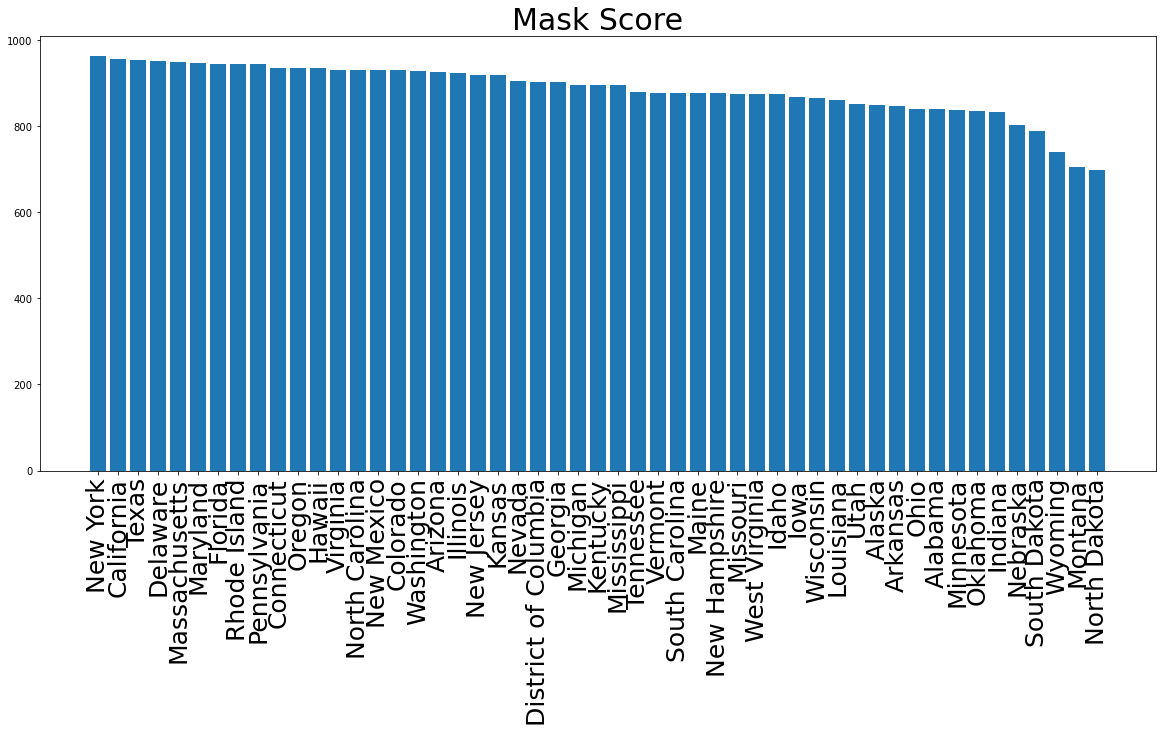

In [188]:
# created bar chart to demonstrate visual of mask score 
fig, ax = plt.subplots(figsize=(20,8))
ax.bar(x_values, y_values)
plt.xticks(rotation=90)
plt.xticks(fontsize=25)
ax.set_title("Mask Score", fontsize=30)
# ax.grid()
plt.xlim

In [151]:
# Aleena's data merge code starts here

# goal: create the final RBDf by adding Mask Score from merged_df 
# to reorganized_final_merged_caseData

In [ ]:
# Aleena's data merge code ends here

In [ ]:
# Aleena's code starts here

In [ ]:
# Aleena's code ends here

In [ ]:
# Emerson's code ends here for now

In [ ]:
# Aleena's analysis and visualization code starts here

In [ ]:
#

In [ ]:
# Aleena's code ends here

In [ ]:
# Emerson's analysis and visualization code starts here

In [ ]:
#

In [ ]:
# Emerson's code starts here

In [ ]:
# Matt's analysis and visualization code starts here

In [ ]:
# 

In [ ]:
# Matt's code ends here

In [ ]:
# Paul's analysis and visualization code starts here

In [ ]:
# 

In [ ]:
# Paul's code ends here